In [1]:
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
!pip install chromedriver-autoinstaller
!pip install selenium-stealth

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,588 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:14 http://security.ubuntu.com

In [2]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import StaleElementReferenceException, NoSuchElementException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import chromedriver_autoinstaller
from selenium_stealth import stealth
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
from io import BytesIO
import requests

chromedriver_autoinstaller.install()

# Webscraping and Filtering interesting data

In [3]:
def remove_non_recipes(recipes):
  # I noticed that non-recipes don't have a timer, so I will base my filterings on that
  filtered_recipes = []
  for recipe in recipes:
    try:
      timer_div = recipe.find_element(By.CLASS_NAME, "wprm-time-container")
      filtered_recipes.append(recipe)
    except NoSuchElementException:
      continue
  return filtered_recipes

def process_recipe(driver, recipe):
  elements = {}

  link_div = recipe.find_element(By.CLASS_NAME, "post-thumb-img-content")
  link = link_div.find_element(By.TAG_NAME, "a").get_attribute("href")

  # Opening the link in a new tab
  driver.execute_script("window.open(arguments[0], '_blank');", link)
  driver.switch_to.window(driver.window_handles[1])

  elements["title"] = driver.find_element(By.CLASS_NAME, "entry-title").text
  elements["image"] = driver.find_element(By.CLASS_NAME, "dpsp-pin-it-wrapper").find_element(By.TAG_NAME, "img").get_attribute("src")
  elements["recipe keys"] = []

  try:
    recipe_keys_li = driver.find_element(By.CLASS_NAME, "post-meta-detail ").find_elements(By.TAG_NAME, "li")
    for rk_li in recipe_keys_li:
      recipe_key = rk_li.find_element(By.TAG_NAME, "a").get_attribute("title")
      elements["recipe keys"].append(recipe_key)
  except:
    pass

  try:
    elements["personal points"] = driver.find_element(By.CLASS_NAME, "recipe-ww-pp").text
  except:
    elements["personal points"] = None

  try:
    elements["calories"] = driver.find_element(By.CLASS_NAME, "wprm-recipe-calories").text
  except:
    elements["calories"] = None

  try:
    elements["summary"] = driver.find_element(By.CLASS_NAME, "entry-content").find_element(By.TAG_NAME, "p").text
  except:
    elements["summary"] = None

  driver.close()
  driver.switch_to.window(driver.window_handles[0])

  return elements

In [4]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome(options=options)

stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )

url = "https://www.skinnytaste.com/"
driver.get(url)

# We land on the home page and in order to go to all the recipes, a button must be clicked
more_recipes_button = driver.find_element(By.CSS_SELECTOR, '[href="/recipe-index/"]')
print(more_recipes_button.text)
more_recipes_button.click()

MORE RECIPES


In [5]:
# Scraping the first 50 pages
recipes_scraped = []
next_page = 2

while next_page <= 51:
  print(f"On page {next_page - 1}")

  main_div = driver.find_element(By.CLASS_NAME, "ast-row")
  recipes = main_div.find_elements(By.TAG_NAME, "article")

  print(f"Found {len(recipes)} potential recipes")
  recipes = remove_non_recipes(recipes)
  print(f"True number of recipes is {len(recipes)}")

  for recipe in recipes:
    recipe_elements = process_recipe(driver, recipe)
    print(recipe_elements)
    recipes_scraped.append(recipe_elements)

  try:
    next_page_button = driver.find_element(By.CLASS_NAME, "next")
    driver.execute_script("arguments[0].click();", next_page_button)
    WebDriverWait(driver, 30).until(EC.staleness_of(main_div))
    next_page += 1
  except NoSuchElementException:
    print("No more pages")
    break

On page 1
Found 20 potential recipes
True number of recipes is 17
{'title': 'Breakfast Burritos', 'image': 'https://www.skinnytaste.com/wp-content/uploads/2019/03/Breakfast-Burritos-21.jpg', 'recipe keys': ['Air Fryer Recipes', 'Freezer Meals', 'High-Fiber Recipes', 'Kid Friendly', 'Meal Prep Recipes', 'Under 30 Minutes'], 'personal points': '5', 'calories': '261', 'summary': 'These freezer breakfast burritos are stuffed with scrambled eggs, scallions, bell pepper, bacon, and cheese, making them a delicious, protein-packed way to start the day! Freeze them for meal prep so you can have them ready all week long.'}
{'title': 'Crustless Pumpkin Pie', 'image': 'https://www.skinnytaste.com/wp-content/uploads/2024/09/Crustless-Pumpkin-Pies-10.jpg', 'recipe keys': ['Dairy Free Recipes', 'Gluten Free', 'High-Fiber Recipes', 'Vegetarian Meals'], 'personal points': '2', 'calories': '124.5', 'summary': 'Skip the crust and make this easy gluten-free, dairy-free crustless pumpkin pie this fall for 

KeyboardInterrupt: 

In [ ]:
driver.quit()

recipes_df = pd.DataFrame(recipes_scraped)
recipes_df.to_csv("recipes.csv")
recipes_df

# EDA and Visualisation

In [8]:
# If you want to load data through the csv file provided, first upload it to the session storage
# recipes_df = pd.read_csv("recipes.csv")
# recipes_df.drop(columns=["Unnamed: 0"], inplace=True)

recipes_df["personal points"] = pd.to_numeric(recipes_df["personal points"], errors='coerce')
recipes_df["calories"] = pd.to_numeric(recipes_df["calories"], errors='coerce')

# Converting recipe keys string list into an actual list
recipes_df["recipe keys"] = recipes_df["recipe keys"].apply(lambda x: eval(x))

In [9]:
# Some recipes didn't have information about personal points, or calories
# One recipe didn't follow the structure of the rest of the pages, so it's summary couldn't be scraped without introducing additional conditions and complicating the code
# I will be ignoring them during the analysis
recipes_df.isna().sum()

,0
title,0
image,0
recipe keys,0
personal points,6
calories,4
summary,1


In [5]:
print(recipes_df[recipes_df["calories"].isna()].title)
print(recipes_df[recipes_df["personal points"].isna()].title)
print(recipes_df[recipes_df["summary"].isna()].title)

242               Vegetable Charcuterie Board
285    How To Make a Colorful Crudite Platter
287              Air Fryer Rotisserie Chicken
364           How To Make a Charcuterie Board
Name: title, dtype: object
242                          Vegetable Charcuterie Board
285               How To Make a Colorful Crudite Platter
287                         Air Fryer Rotisserie Chicken
364                      How To Make a Charcuterie Board
647                                        “Fried” Oreos
648    Salmon Salad with Beets, Arugula, Pistachios a...
Name: title, dtype: object
562    Shredded Brussels Sprouts with Pancetta
Name: title, dtype: object


In [ ]:
recipes_df.describe()

,personal points,calories
count,933.000000,935.000000
mean,4.961415,237.369412
std,2.794962,116.442076
min,0.000000,8.000000
25%,3.000000,147.000000
50%,5.000000,225.000000
75%,7.000000,308.000000
max,13.000000,608.000000


In [11]:
# Exploding the 'recipe keys' column so each key is its own row
exploded_keys = recipes_df.explode('recipe keys')
print(exploded_keys.shape)
frequency_dict = exploded_keys['recipe keys'].value_counts().to_dict()
print(frequency_dict)

(3812, 6)
{'Gluten Free': 695, 'Kid Friendly': 512, 'Under 30 Minutes': 458, 'Dairy Free Recipes': 440, 'Vegetarian Meals': 403, 'Low Carb': 270, 'High-Fiber Recipes': 241, 'High Protein Recipes': 210, 'Meal Prep Recipes': 148, 'Freezer Meals': 142, 'Whole30 Recipes': 120, 'Air Fryer Recipes': 101, 'Pressure Cooker Recipes': 34, 'Slow Cooker Recipes': 28}


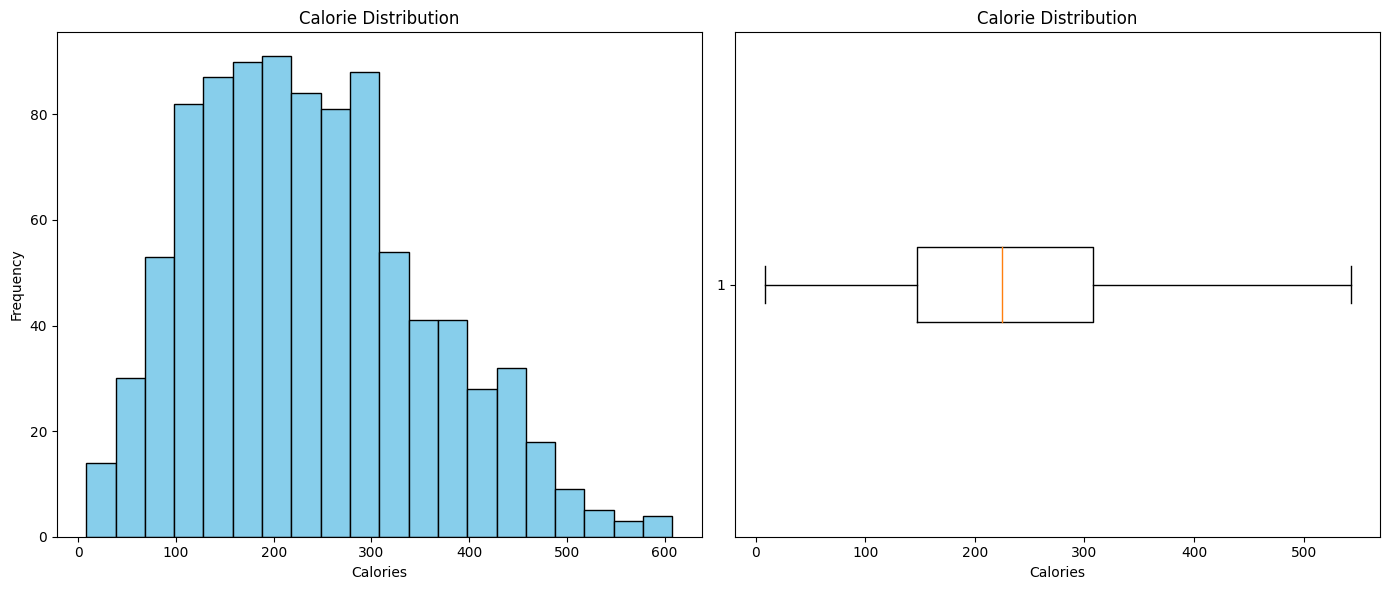

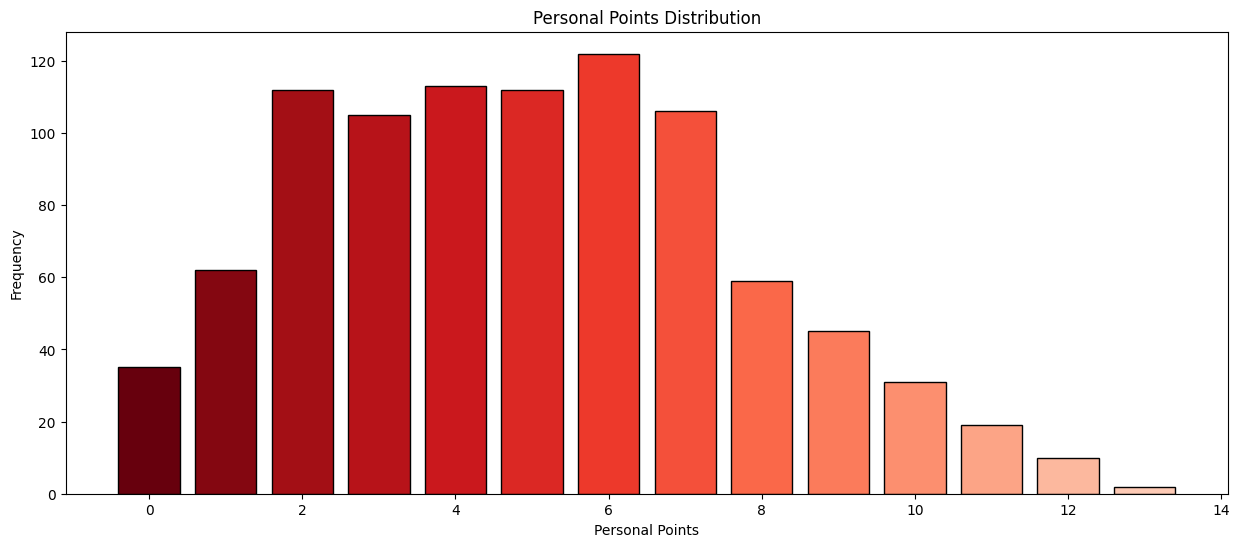

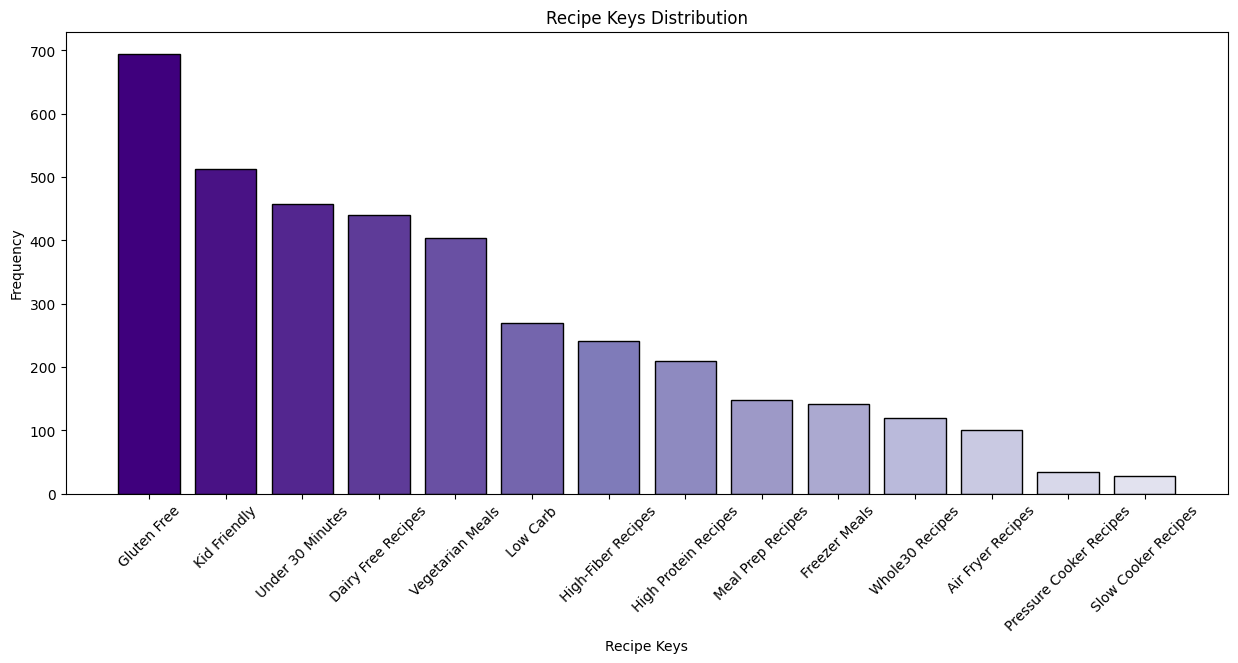

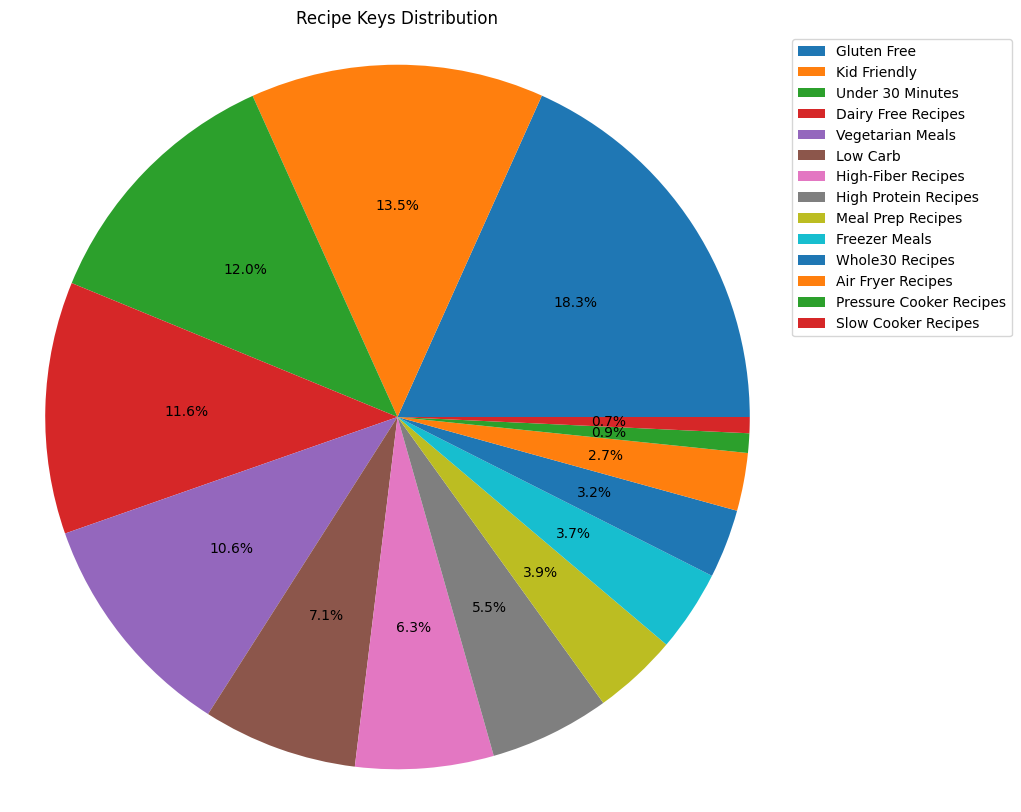

In [19]:
calories_data = recipes_df['calories'].dropna()
points_data = recipes_df['personal points'].dropna()
points_count = points_data.value_counts().sort_index()

# Calorie distribution - Histogram and Box plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot - Histogram
axes[0].hist(calories_data, color='skyblue', edgecolor='black', bins=20)
axes[0].set_title('Calorie Distribution')
axes[0].set_xlabel('Calories')
axes[0].set_ylabel('Frequency')

# Second plot - Box plot
axes[1].boxplot(calories_data, vert=False, showfliers=False)
axes[1].set_title('Calorie Distribution')
axes[1].set_xlabel('Calories')

plt.tight_layout()
plt.show()

# Personal points distribution - Bar plot
plt.figure(figsize=(15, 6))
plt.bar(points_count.index, points_count.values, color=plt.cm.Reds(np.linspace(1,0.2,len(frequency_dict.keys()))), edgecolor='black')
plt.title('Personal Points Distribution')
plt.xlabel('Personal Points')
plt.ylabel('Frequency')
plt.show()

# Recipe keys distribution - Bar plot and Pie chart

# First plot - Bar plot
plt.figure(figsize=(15, 6))
plt.bar(frequency_dict.keys(), frequency_dict.values(), color=plt.cm.Purples(np.linspace(1,0.2,len(frequency_dict.keys()))), edgecolor='black')
plt.title('Recipe Keys Distribution')
plt.xlabel('Recipe Keys')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Second plot - Pie chart
plt.figure(figsize=(10, 10))
plt.pie(frequency_dict.values(), autopct='%1.1f%%')
plt.legend(labels=frequency_dict.keys(), loc="upper left", bbox_to_anchor=(1, 1))
plt.title('Recipe Keys Distribution')
plt.axis('equal')

plt.show()

0.6470718864201456
0.6418207772503749
Conclusion is that we have a linear and positive correlation between personal points and calories


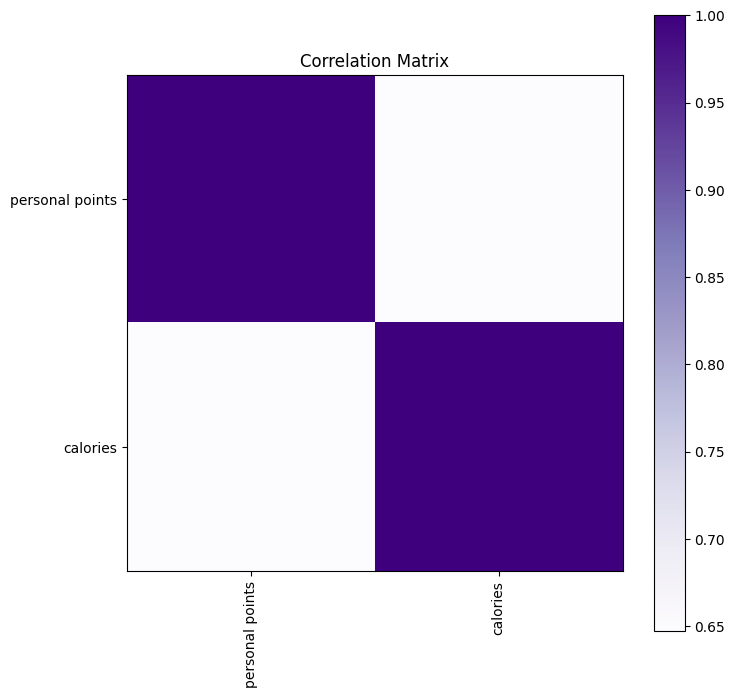

In [16]:
# Correlation on the numeric columns
# linear and monotonic correlation
print(recipes_df.calories.corr(recipes_df["personal points"], method="pearson"))
print(recipes_df.calories.corr(recipes_df["personal points"], method="spearman"))
print("Conclusion is that we have a linear and positive correlation between personal points and calories")

# Visual representation
correlation_matrix = recipes_df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(8, 8))
plt.imshow(correlation_matrix, cmap='Purples', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

# User interaction

In [30]:
def display_recipe(recipe):
  print(f"Title: {recipe['title']}, Calories: {recipe['calories']}, Personal Points: {recipe['personal points']}")
  print(f"Summary: {recipe['summary']}")

  if recipe["image"] is not None:
    plt.figure(figsize=(6, 6))
    response = requests.get(recipe["image"])
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.axis("off")
    plt.title(recipe["title"])
    plt.show()
  else:
    print("No image available")

def execute(button):
  clear_output(wait=True)
  display(min_calories, max_calories, min_points, max_points)
  display(button)

  calories_min, calories_max, points_min, points_max = get_widget_values()
  print(f"Calorie range is from {calories_min} to {calories_max}")
  print(f"Points range is from {points_min} to {points_max}\n")

  filtered_df = recipes_df[(recipes_df["calories"] >= calories_min) & (recipes_df["calories"] <= calories_max)]
  filtered_df = filtered_df[(filtered_df["personal points"] >= points_min) & (filtered_df["personal points"] <= points_max)]
  filtered_df = filtered_df.sort_values(by="calories", ascending=False)
  filtered_df = filtered_df.iloc[0:10]

  for index, recipe in filtered_df.iterrows():
    display_recipe(recipe)

In [31]:
min_calorie_value = recipes_df["calories"].min()
max_calorie_value = recipes_df["calories"].max()

min_points_value = recipes_df["personal points"].min()
max_points_value = recipes_df["personal points"].max()

def get_widget_values():
    min_calories_value = min_calories.value
    max_calories_value = max_calories.value
    min_points_value = min_points.value
    max_points_value = max_points.value

    return min_calories_value, max_calories_value, min_points_value, max_points_value

min_calories = widgets.IntText(
    value=min_calorie_value,
    description='Min Calories:',
    disabled=False
)
max_calories = widgets.IntText(
    value=max_calorie_value,
    description='Max Calories:',
    disabled=False
)

min_points = widgets.IntText(
    value=min_points_value,
    description='Min Points:',
    disabled=False
)
max_points = widgets.IntText(
    value=max_points_value,
    description='Max Points:',
    disabled=False
)

print("Modify these values in the fields directly and execute the next cell when ready")
display(min_calories, max_calories, min_points, max_points)

# Button for execution
button = widgets.Button(description="Execute")
button.on_click(execute)
display(button)

Output hidden; open in https://colab.research.google.com to view.